<a href="https://colab.research.google.com/github/rubychen8407/brain-tumor-semantic-segmentation/blob/main/Tumor_Seg_deeplabv3_balenced_loss_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Apr 25 10:28:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **save picture**

In [ ]:
import os

PROJECT_ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/HW2_Segmentation_MRI_project"

def save_fig(image_name,tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(PROJECT_ROOT_DIR, "image",image_name + "." + fig_extension)

  if tight_layout:
        plt.tight_layout()
  return plt.savefig(path, format=fig_extension, dpi=resolution)

# Download package

In [ ]:
!git clone https://github.com/samson6460/tf2_Segmentation.git

Cloning into 'tf2_Segmentation'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 56 (delta 24), reused 47 (delta 15), pack-reused 0
Unpacking objects: 100% (56/56), done.


# Load datasets

In [ ]:
from tf2_Segmentation.utils import Segdata_reader
from tf2_Segmentation.utils import vis_img_mask

In [ ]:
!pip install imgaug==0.4.0

In [ ]:
import imgaug

imgaug.__version__

'0.4.0'

In [ ]:
import imgaug.augmenters as iaa

augmenter = iaa.Sequential([
    #iaa.Dropout([0.05, 0.2]),      # drop 5% or 20% of all pixels
    #iaa.Sharpen((0.0, 1.0)),       # sharpen the image
    iaa.Affine(rotate=(-45, 45)),   # rotate by -45 to 45 degrees
    #iaa.ElasticTransformation(alpha=50, sigma=5),  # apply water effect
    iaa.Fliplr(0.5),
    iaa.Crop(px=(0, 100)),
    #iaa.Crop(percent=(0, 0.3)),
    iaa.Flipud(0.5),
    ], 
    random_order=True)

In [ ]:
train_sreader = Segdata_reader(
    rescale=1/255,
    augmenter=augmenter,
    aug_times=5)
train_seq = train_sreader.imglayer_to_sequence(
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/Brain_Tumour_Segmentation/Train/img",
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/Brain_Tumour_Segmentation/Train/label",
    batch_size=5,
    class_colors=["w"],
    size=(416, 416))

In [ ]:
valid_sreader = Segdata_reader(rescale=1/255)
valid_seq = valid_sreader.imglayer_to_sequence(
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/Brain_Tumour_Segmentation/Valid/img",
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/Brain_Tumour_Segmentation/Valid/label",
    batch_size=5,
    class_colors=["w"],
    size=(416, 416))

In [ ]:
train_seq_data, train_seq_label = train_seq[0]

#for i in range(len(train_seq_data)):
    #vis_img_mask(train_seq_data[i], train_seq_label[i])

# **U-net(relu)**

In [ ]:
from tf2_Segmentation.models import unet

In [ ]:
# pretrained_weights = "/content/drive/MyDrive/YM/UNET/weights/brain_tumor_416.h5"
# pretrained_weights = "/content/drive/MyDrive/YM/UNET/weights/brain_tumor_416_ce.h5"

model = unet(
    input_shape=(416, 416, 3),
    activation='relu',
    categorical_num=1,
    # pretrained_weights=pretrained_weights
    )

In [ ]:
model.summary()

# **U-net(selu)**

In [ ]:
from tf2_Segmentation.models import unet

In [ ]:
model = unet(
    input_shape=(416, 416, 3),
    activation='selu',
    categorical_num=1,
    # pretrained_weights=pretrained_weights
    )

# ***deeplabv3***

In [ ]:
from tf2_Segmentation.models import deeplabv3

In [ ]:
model = deeplabv3(
    pretrained_weights='pascal_voc',
    input_tensor=None,
    input_shape=(416, 416, 3),
    classes=None,
    categorical_num=1,
    backbone='xception',
    OS=16, alpha=1.,
    activation="softmax")

166100992/166096424 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 208, 208, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 208, 208, 32) 128         entry_flow_conv1_1[0][0]         
__________________________________________________________________________________________________
activation (Activation)         (None, 208, 208, 32) 0           entry_flow_conv1_1_BN[0][0]      
______________________________________________________________________________________

# Compile the model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tf2_Segmentation.losses import dice_loss_func
from tf2_Segmentation.losses import balanced_categorical_crossentropy
from tf2_Segmentation.utils import get_class_weight
from tf2_Segmentation.metrics import dice_coef_func

In [ ]:
class_weight = get_class_weight(train_seq_label,method='effective')
print(class_weight) #mask跟沒有mask的比例

[1.96891615 0.03108385]


In [ ]:
model.compile(
    optimizer=Adam(lr=1e-5),
    loss=balanced_categorical_crossentropy(
        class_weight=class_weight),
    metrics=[dice_coef_func()])

In [ ]:
"""model.compile(
    optimizer=Adam(lr=1e-5),
    loss=dice_loss_func(smooth=1),
    metrics=["accuracy"])"""

'model.compile(\n    optimizer=Adam(lr=1e-5),\n    loss=dice_loss_func(smooth=1),\n    metrics=["accuracy"])'

## Train from sequence

In [ ]:
history = model.fit(
    train_seq,
    epochs=10,
    validation_data=valid_seq)

Epoch 1/10
1280/1280 [==============================] - 1186s 890ms/step - loss: 0.0235 - dice_coef: 0.5904 - val_loss: 0.0072 - val_dice_coef: 0.9040
Epoch 2/10
1280/1280 [==============================] - 989s 772ms/step - loss: 0.0076 - dice_coef: 0.8663 - val_loss: 0.0047 - val_dice_coef: 0.9527
Epoch 3/10
1280/1280 [==============================] - 988s 772ms/step - loss: 0.0054 - dice_coef: 0.9059 - val_loss: 0.0041 - val_dice_coef: 0.9605
Epoch 4/10
1280/1280 [==============================] - 987s 771ms/step - loss: 0.0043 - dice_coef: 0.9211 - val_loss: 0.0042 - val_dice_coef: 0.9657
Epoch 5/10
1280/1280 [==============================] - 988s 772ms/step - loss: 0.0035 - dice_coef: 0.9326 - val_loss: 0.0043 - val_dice_coef: 0.9796
Epoch 6/10
1280/1280 [==============================] - 987s 771ms/step - loss: 0.0031 - dice_coef: 0.9373 - val_loss: 0.0040 - val_dice_coef: 0.9831
Epoch 7/10
1280/1280 [==============================] - 1004s 784ms/step - loss: 0.0027 - dice_coef

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/HW2_Segmentation_MRI_project/model/deeplabv3_aug/weights.h5")

# **save model**

In [ ]:
import os

def model_savebymodel(model_name, style="h5"):
  model_name=list("deeplabv3_aug","unet_relu_aug","unet_selu_aug")
  model_root_dir = "/content/drive/MyDrive/Colab Notebooks/HW2_Segmentation_MRI_project/model/"
  return model.save(os.path.join(model_root_dir, model_name, "weights." + style))

In [ ]:
"""weight_path=model_savebymodel(model_name="deeplabv3_aug")"""

'weight_path=model_savebymodel(model_name="deeplabv3_aug")'

## **trainig history**

In [ ]:
print(history)

In [ ]:
history.history.keys()

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])

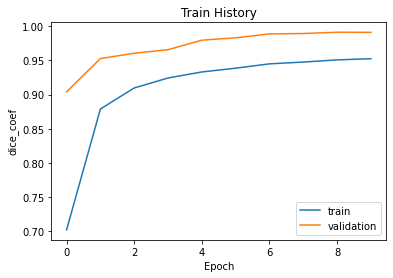

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Train History')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('train_History_dice_coef.png')

plt.show()

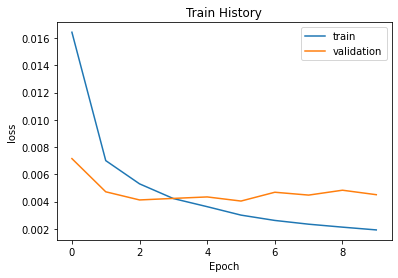

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train History')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('train_History_loss.png')

plt.show()

# **Draw the training processing plot**

In [ ]:
from tf2_Segmentation.utils import plot_history

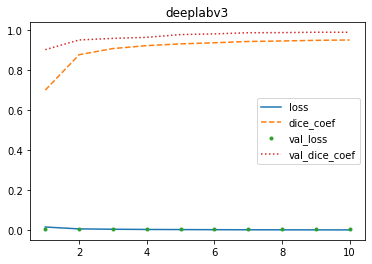

In [ ]:
accuracy_history = plot_history(history_dict=history.history, keys=('loss', 'dice_coef', 'val_loss', 'val_dice_coef'), xyLabel=[('epoch', 'dice_coef')], title="deeplabv3",  size=(6,4))

#https://github.com/samson6460/tf2_Segmentation/blob/master/utils/tools.py"""

In [ ]:
save_fig("deeplabv3")

# Test

In [ ]:
from keras.models import load_model

In [ ]:
#?load_model

In [ ]:
#model = load_model(weight_path, custom_objects = {"dice_loss_func":dice_loss_func}, compile=False)

In [ ]:
from tf2_Segmentation.models import model_predict

In [ ]:
test_sreader = Segdata_reader(rescale=1/255)
test_data, test_label = test_sreader.imglayer_to_dataset(
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/Brain_Tumour_Segmentation/Test/img",
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/Brain_Tumour_Segmentation/Test/label",
    class_colors=["w"],
    size=(416, 416),
    thread_num=1000)

In [ ]:
prediction = model_predict(
    model, test_data,
    batch_size=3,
    verbose=1)

54/54 [==============================] - 9s 118ms/step


groundtruth:


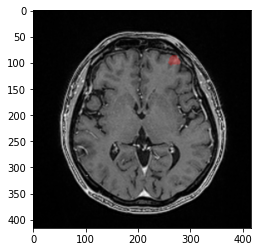

prediction:


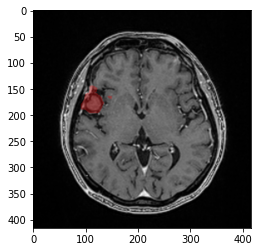

groundtruth:


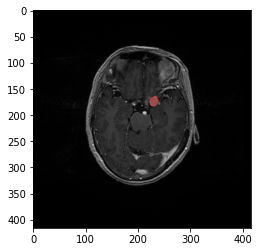

prediction:


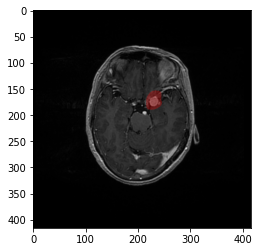

groundtruth:


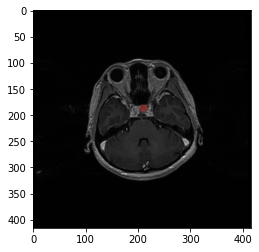

prediction:


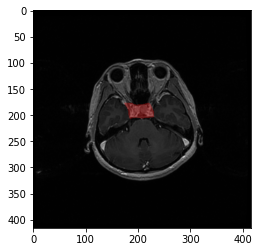

groundtruth:


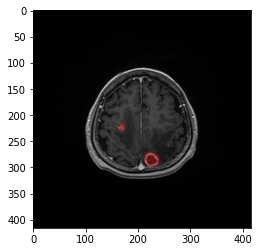

prediction:


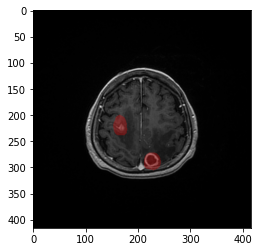

groundtruth:


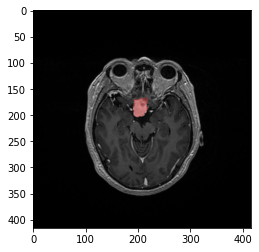

prediction:


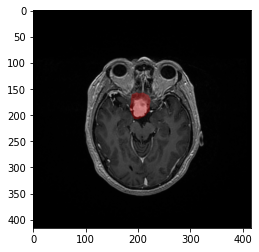

groundtruth:


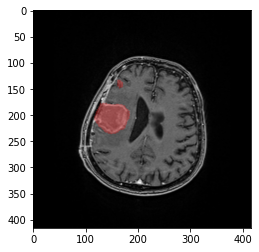

prediction:


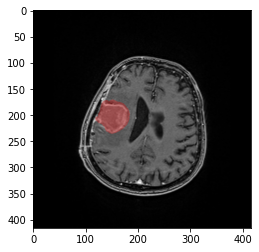

groundtruth:


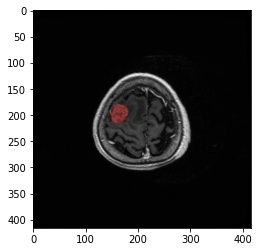

prediction:


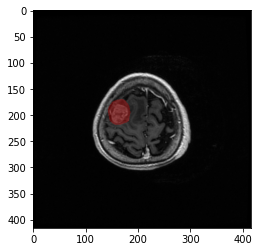

groundtruth:


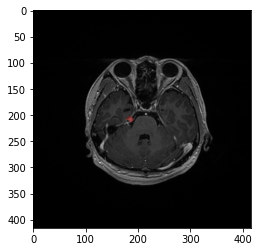

prediction:


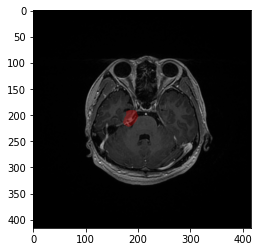

groundtruth:


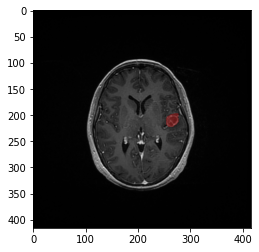

prediction:


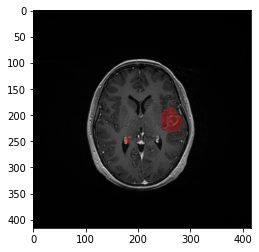

groundtruth:


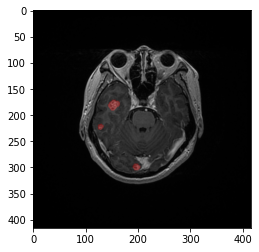

prediction:


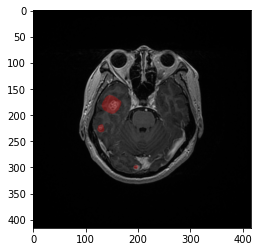

groundtruth:


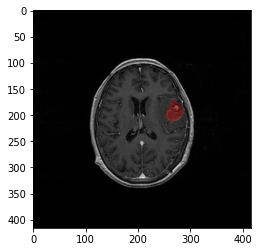

prediction:


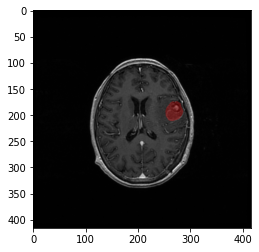

groundtruth:


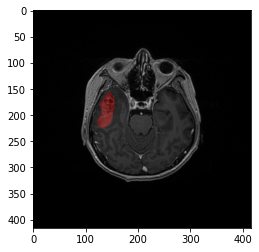

prediction:


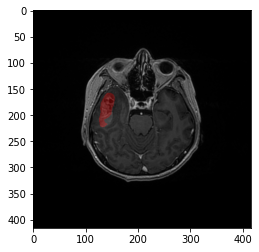

groundtruth:


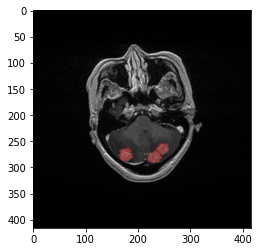

prediction:


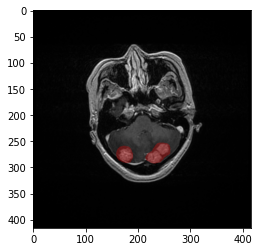

groundtruth:


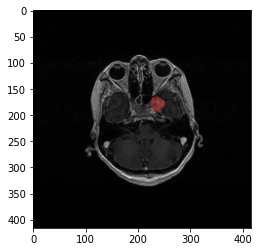

prediction:


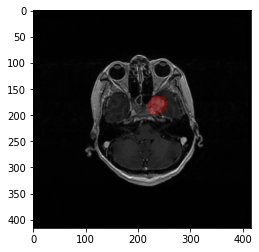

groundtruth:


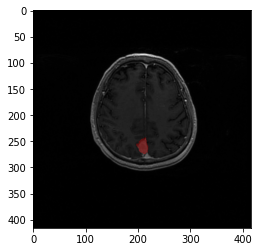

prediction:


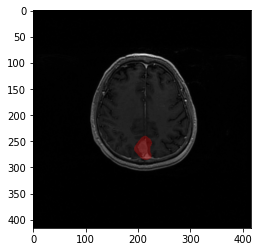

groundtruth:


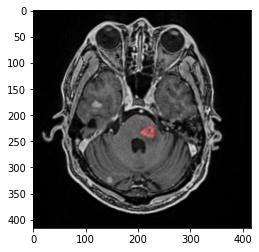

prediction:


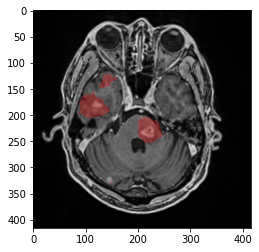

groundtruth:


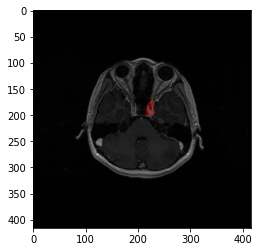

prediction:


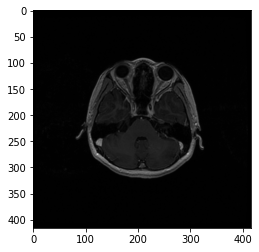

groundtruth:


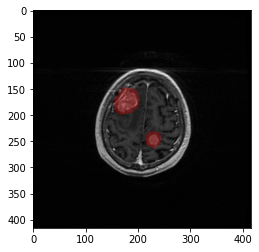

prediction:


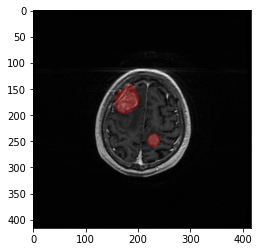

groundtruth:


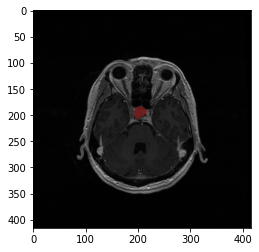

prediction:


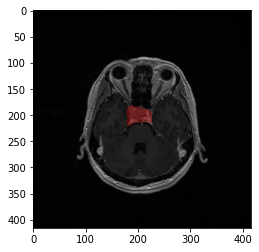

groundtruth:


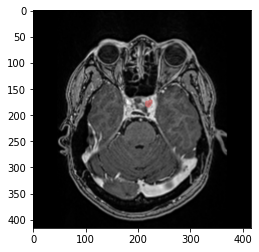

prediction:


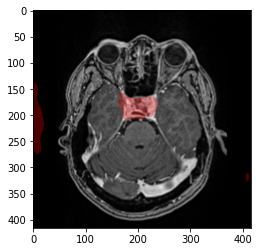

In [ ]:
for i in range(20):
    print("groundtruth:")
    vis_img_mask(test_data[i], test_label[i])
    print("prediction:")
    vis_img_mask(test_data[i], prediction[i])
    print("==================================")

# Show measurement

In [ ]:
from tf2_Segmentation.utils import get_dice
from tf2_Segmentation.utils import create_confusion_mat
from tf2_Segmentation.utils import create_score_mat, get_iou, get_jaccard
from tf2_Segmentation.metrics import be_binary_accuracy, dice_coef_func

In [ ]:
#get_iou(test_label, prediction, class_names=["tumor"], classifi_mode='one')

In [ ]:
get_dice(test_label, prediction, class_names=["tumor"])

tumor    0.516752
dtype: float64

In [ ]:
confusion_mat = create_confusion_mat(
    test_label, prediction,
    class_names=["tumor"])

confusion_mat

prediction,tumor,nothing
groundtruth,,
tumor,99739,19107
nothing,167438,27402676


In [ ]:
create_score_mat(confusion_mat)

,precision,recall,specificity,F1-score
tumor,0.373307,0.839229,0.993927,0.516752
nothing,0.999303,0.993927,0.839229,0.996608


In [ ]:
#get_jaccard(test_label, prediction, class_names=["tumor"], classifi_mode='one')

In [ ]:
be_binary_accuracy(test_label, prediction)